In [1]:
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = "mu3e_trigger_data"
SIGNAL_DATA_FILE = f"{DATA_DIR}/run42_sig_positions.npy"
BACKGROUND_DATA_FILE = f"{DATA_DIR}/run42_bg_positions.npy"

max_barrel_radius = 86.3
max_endcap_distance = 372.6


In [3]:
signal_data = np.load(SIGNAL_DATA_FILE)
background_data = np.load(BACKGROUND_DATA_FILE)

background_data[background_data[:,:,0] != -1, 0] /= max_barrel_radius
background_data[background_data[:,:,0] != -1, 1] /= max_barrel_radius
background_data[background_data[:,:,0] != -1, 2] /= max_endcap_distance

signal_data[signal_data[:,:,0] != -1, 0] /= max_barrel_radius
signal_data[signal_data[:,:,0] != -1, 1] /= max_barrel_radius
signal_data[signal_data[:,:,0] != -1, 2] /= max_endcap_distance


243


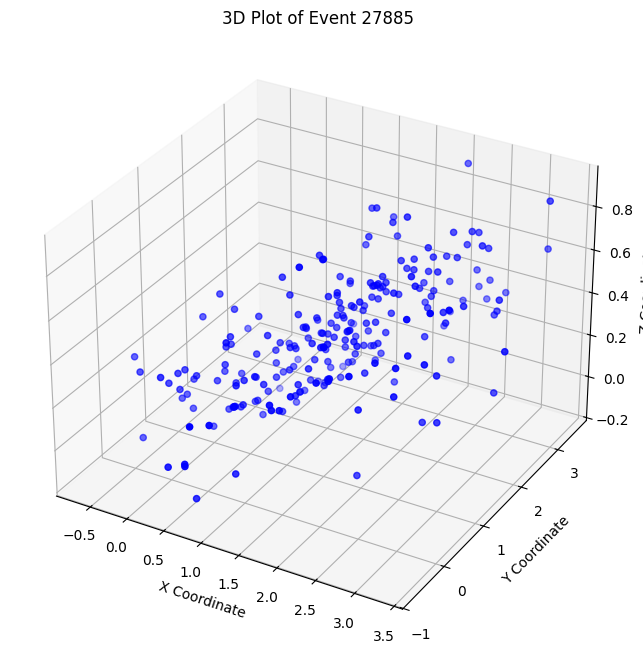

In [4]:
import matplotlib
#matplotlib.use('Qt5Agg')
hit_number = ((background_data != -1).all(axis = -1)).sum(axis=-1)

event_index = np.argmax(hit_number)  # Index of the event to plot
print(hit_number[event_index])
event_location = background_data[event_index]

# Filter out padding values
valid_mask = ~(event_location == -1).any(axis=-1)
event_location = event_location[valid_mask]

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(event_location[:, 0], event_location[:, 1], event_location[:, 2], c='b', marker='o')

ax.set_xlabel('X Coordinate')
ax.set_ylabel('Y Coordinate')
ax.set_zlabel('Z Coordinate')
ax.set_title(f'3D Plot of Event {event_index}')

plt.show()

In [5]:
from keras.losses import Loss
from keras.metrics import Metric

@keras.utils.register_keras_serializable(package='Custom', name='ChamferDistanceMasked')
class ChamferDistanceMasked(Loss):
    def __init__(self, padding_val=-1.0, name='chamfer_distance_masked'):
        super().__init__(name=name)
        self.padding_val = padding_val

    def call(self, y_true, y_pred):
        """
        y_true: (B, N, D)
        y_pred: (B, M, D)
        """
        padding_val = self.padding_val

        # Masks: (B, N) and (B, M)
        mask_true = tf.reduce_any(tf.not_equal(y_true, padding_val), axis=-1)  # valid = True
        mask_pred = tf.reduce_any(tf.not_equal(y_pred, padding_val), axis=-1)

        # Expand dims for broadcasting
        y_true_exp = tf.expand_dims(y_true, axis=2)  # (B, N, 1, D)
        y_pred_exp = tf.expand_dims(y_pred, axis=1)  # (B, 1, M, D)

        # Compute squared distances
        diff = y_true_exp - y_pred_exp
        dist = tf.reduce_sum(tf.square(diff), axis=-1)  # (B, N, M)

        # Min distances
        min_true_to_pred = tf.reduce_min(dist, axis=2)  # (B, N)
        min_pred_to_true = tf.reduce_min(dist, axis=1)  # (B, M)

        # Zero-out invalid entries (inf) and compute mean over valid
        valid_min_true_to_pred = tf.where(mask_true, min_true_to_pred, tf.zeros_like(min_true_to_pred))
        valid_min_pred_to_true = tf.where(mask_pred, min_pred_to_true, tf.zeros_like(min_pred_to_true))

        sum_true = tf.reduce_sum(valid_min_true_to_pred)
        sum_pred = tf.reduce_sum(valid_min_pred_to_true)

        count_true = tf.reduce_sum(tf.cast(mask_true, tf.float32))
        count_pred = tf.reduce_sum(tf.cast(mask_pred, tf.float32))

        # Avoid division by zero
        mean_true_to_pred = sum_true / (count_true + 1e-8)
        mean_pred_to_true = sum_pred / (count_pred + 1e-8)

        return mean_true_to_pred + mean_pred_to_true
    

In [6]:
class LearnedSeedVectors(keras.Model):
    def __init__(self, num_seeds, seed_dim, **kwargs):
        super(LearnedSeedVectors, self).__init__(**kwargs)
        self.seeds = tf.Variable(tf.random.normal([num_seeds, seed_dim]), trainable=True)

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Repeat the seeds for each batch element
        seeds = tf.repeat(self.seeds[tf.newaxis, :, :], batch_size, axis=0)
        return seeds

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])
    
class OutputSeedVectors(keras.Model):
    def __init__(self, num_seeds, seed_dim, **kwargs):
        super(OutputSeedVectors, self).__init__(**kwargs)
        self.seeds = tf.constant(tf.range(0, num_seeds * seed_dim, dtype=tf.float32), shape=(num_seeds, seed_dim))

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        # Repeat the seeds for each batch element
        seeds = tf.repeat(self.seeds[tf.newaxis, :, :], batch_size, axis=0)
        return seeds

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.seeds.shape[0], self.seeds.shape[1])

class GenerateMask(keras.Model):
    def __init__(self, padding_value = -1, **kwargs):
        super(GenerateMask, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.not_equal(inputs, self.padding_value)
        return tf.reduce_any(mask, axis=-1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return input_shape[:-1] + (input_shape[-1],)
    
class GenerateAttentionMask(keras.Model):
    def __init__(self, padding_value = -1, **kwargs):
        super(GenerateAttentionMask, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs):
        mask = tf.not_equal(inputs, self.padding_value)
        mask = tf.reduce_any(mask, axis=-1)  # Reduce to a 1D mask
        return tf.expand_dims(mask, axis=1)  # Expand dims to match attention mask shape

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1, *input_shape)


class MaskOutput(keras.layers.Layer):
    def __init__(self, padding_value=-1, **kwargs):
        super(MaskOutput, self).__init__(**kwargs)
        self.padding_value = padding_value

    def call(self, inputs, mask=None):
        if mask is not None:
            inputs = tf.where(mask, inputs, self.padding_value * tf.ones_like(inputs, dtype=inputs.dtype))
        return inputs

    def compute_output_shape(self, input_shape):
        return input_shape



class GetSequenceLength(keras.layers.Layer):
    def __init__(self, **kwargs):
        super(GetSequenceLength, self).__init__(**kwargs)

    def call(self, inputs):
        mask = tf.cast(inputs, tf.int32)
        mask = tf.squeeze(mask, axis=-1)  # Remove the last dimension if it exists
        return tf.reduce_sum(mask, axis=-1, keepdims=True)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], 1)


class GenerateDecoderMask(keras.layers.Layer):
    def __init__(self, max_length=256, **kwargs):
        super().__init__(**kwargs)
        self.max_length = max_length

    def call(self, inputs):
        # inputs: shape (batch_size, 1) or (batch_size,)
        predicted_seq_length = tf.cast(tf.round(tf.squeeze(inputs, axis=-1)), tf.int32)
        # clip to max_length
        predicted_seq_length = tf.clip_by_value(predicted_seq_length, 0, self.max_length)
        # create sequence mask
        mask = tf.sequence_mask(predicted_seq_length, maxlen=self.max_length, dtype=tf.bool)
        # expand dims to (batch_size, max_length, 1)
        return tf.expand_dims(mask, axis=-1)

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.max_length, 1)


In [7]:
input = keras.Input(shape=(256, 3), name="input_layer")

latent_dim = 30

# Build encoder
mask = GenerateMask(padding_value=-1, name="mask_layer")(input)
sequence_length_input = GetSequenceLength(name="sequence_length_layer")(mask)
flatted_mask = keras.layers.Flatten(name="flatten_mask_layer")(mask)
input_embedding = keras.layers.Dense(8, activation='relu', name="input_embedding_layer")(input)

multi_head = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="multi_head_attention_layer")(input_embedding, input_embedding, attention_mask=mask)
normalised_residual = keras.layers.LayerNormalization(name="normalised_residual_layer")(multi_head + input_embedding)
dense_layer = keras.layers.Dense(8, activation='relu', name="dense_layer")(normalised_residual)
transformer_output = keras.layers.LayerNormalization(name="transformer_output_layer")(dense_layer + normalised_residual)
seed_vectors = LearnedSeedVectors(num_seeds=1, seed_dim=latent_dim, name="seed_vectors_layer")(transformer_output)

ff_transformer_output = keras.layers.Dense(8, activation='relu', name="ff_transformer_output_layer")(transformer_output)

fixed_size_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="fixed_size_attention_layer")(
    seed_vectors, ff_transformer_output, ff_transformer_output, value_mask=flatted_mask)

fixed_size_output = keras.layers.LayerNormalization(name="fixed_size_output_layer")(fixed_size_output + seed_vectors)
fixed_size_output = keras.layers.Dense(latent_dim, activation='relu', name="fixed_size_dense_layer")(fixed_size_output)
fixed_size_output = keras.layers.LayerNormalization(name="fixed_size_normalization_layer")(fixed_size_output + seed_vectors)

latent_fixed_size = keras.layers.Flatten(name="latent_flatted")(fixed_size_output)
embedded_sequence_length = keras.layers.Dense(latent_dim, activation='linear', name="embedded_sequence_length_layer")(sequence_length_input)


latent_output = keras.layers.Add(name="latent_output_layer")([latent_fixed_size, embedded_sequence_length])

# Decoder layers using a multi-head attention mechanism
decoder_sequence_length_sigmoid = keras.layers.Dense(1, activation='linear', name="sequence_length")(latent_output)


decoder_mask = GenerateDecoderMask(max_length=256, name="decoder_mask_layer")(decoder_sequence_length_sigmoid)
decoded_latent_output = keras.layers.Dense(latent_dim, activation='relu', name="decoded_latent_output_layer")(latent_output)
decoded_latent_output_reshape = keras.layers.Reshape((latent_dim, 1), name="decoded_latent_output_reshape_layer")(decoded_latent_output)


decoder_seed_vectors = LearnedSeedVectors(num_seeds=256, seed_dim=latent_dim, name="decoder_seed_vectors_layer")(decoder_mask)
decoder_variable_sized_output = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="decoder_variable_sized_attention_layer")(
    decoder_seed_vectors, decoded_latent_output_reshape, decoded_latent_output_reshape, attention_mask=decoder_mask)
decoder_variable_sized_output = keras.layers.LayerNormalization(name="decoder_variable_sized_output_layer")(decoder_variable_sized_output + decoder_seed_vectors)
decoder_variable_sized_output = keras.layers.Dense(latent_dim, activation='relu', name="decoder_variable_sized_dense_layer")(decoder_variable_sized_output)
decoder_variable_sized_output = keras.layers.LayerNormalization(name="decoder_variable_sized_normalization_layer")(decoder_variable_sized_output + decoder_seed_vectors)

# Self-attention mechanism for the decoder
decoder_self_attention = keras.layers.MultiHeadAttention(num_heads=4, key_dim=8, name="decoder_self_attention_layer")(
    decoder_variable_sized_output, decoder_variable_sized_output, decoder_variable_sized_output, attention_mask = decoder_mask)
decoder_self_attention = keras.layers.LayerNormalization(name="decoder_self_attention_normalization_layer")(decoder_self_attention + decoder_variable_sized_output)
decoder_self_attention = keras.layers.Dense(latent_dim, activation='relu', name="decoder_self_attention_dense_layer")(decoder_self_attention)
decoder_self_attention = keras.layers.LayerNormalization(name="decoder_self_attention_final_layer")(decoder_self_attention + decoder_variable_sized_output)

decoder_output = keras.layers.Dense(3, activation='linear', name="decoder_output_layer")(decoder_self_attention)
# Final output layer
masked_output = MaskOutput(padding_value=-1.0, name="output")(decoder_output, mask=decoder_mask)
length_output = decoder_sequence_length_sigmoid


In [8]:
autoencoder = keras.Model(inputs=[input], outputs=[masked_output, length_output], name="mu3e_trigger_autoencoder")
autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=[ChamferDistanceMasked, 'mse'],)

In [9]:
training_data = background_data[:10000]  # Use a subset for training
tranining_data_sequence_length = np.sum((training_data != -1).any(axis = -1), axis = -1)  # Calculate sequence lengths for the training data


In [10]:

history = autoencoder.fit(training_data, [training_data, tranining_data_sequence_length], epochs=10, batch_size=512, validation_split=0.2)

Epoch 1/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - loss: 1326.2513 - output_loss: 4.3728 - sequence_length_loss: 1320.7106 - val_loss: 154.7655 - val_output_loss: 0.2588 - val_sequence_length_loss: 154.5731
Epoch 2/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 65.9750 - output_loss: 0.2503 - sequence_length_loss: 65.6721 - val_loss: 16.3584 - val_output_loss: 0.2217 - val_sequence_length_loss: 16.1394
Epoch 3/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 2s/step - loss: 8.0792 - output_loss: 0.2112 - sequence_length_loss: 7.8541 - val_loss: 1.0770 - val_output_loss: 0.2027 - val_sequence_length_loss: 0.8754
Epoch 4/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 1.6006 - output_loss: 0.2000 - sequence_length_loss: 1.3967 - val_loss: 0.4867 - val_output_loss: 0.1981 - val_sequence_length_loss: 0.2889
Epoch 5/10
16/16 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - loss: 0.7072 - output_loss: 0.1949 - sequence_length_loss: 0.5119 - val_loss: 0.4720 - val_output_loss: 0.1960 - val_sequence_length_loss: 0.2

In [11]:
test_data = background_data[-5:]  # Use a subset for prediction
test_data_sequence_length = np.sum((test_data != -1).any(axis = -1), axis = -1)  # Calculate sequence lengths for the training data

test_data_prediction, test_data_sequence_length_prediction = autoencoder.predict(test_data)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step


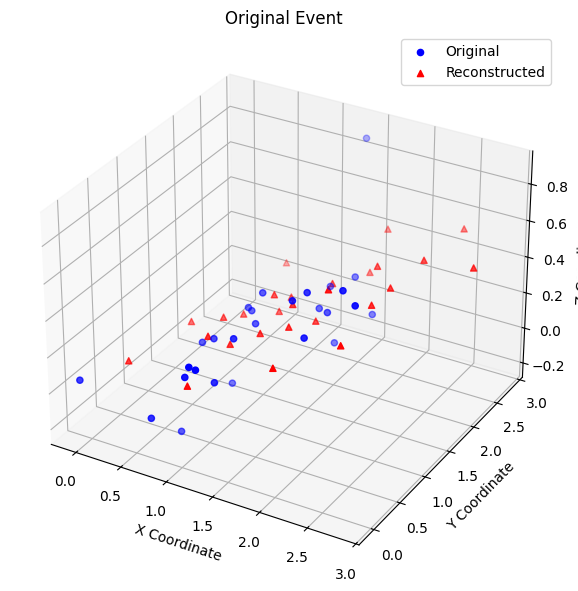

In [12]:
# Select an event to visualize
event_index = 4 # Change this index to visualize a different event
original_event = test_data[event_index, : ,:]
original_event = original_event[~np.all(original_event == -1, axis=1)]  # Filter out rows with all -1
# Filter out padding values
#valid_mask = ~(original_event == -1).any(axis=-1)
#original_event = original_event[valid_mask]

# Get the reconstructed event from the autoencoder
#reconstructed_event = autoencoder.predict([original_event,sequence_length])
reconstructed_event = test_data_prediction[event_index, : ,:]
reconstructed_event = reconstructed_event[~np.all(reconstructed_event == -1, axis=1)]  # Filter out rows with all -1

# Create a 3D plot
fig = plt.figure(figsize=(12, 6))

# Plot original event
ax1 = fig.add_subplot(111, projection='3d')
ax1.scatter(original_event[:, 0], original_event[:, 1], original_event[:, 2], c='b', marker='o', label='Original')
ax1.scatter(reconstructed_event[:, 0], reconstructed_event[:, 1], reconstructed_event[:, 2], c='r', marker='^', label='Reconstructed')

ax1.set_title('Original Event')
ax1.set_xlabel('X Coordinate')
ax1.set_ylabel('Y Coordinate')
ax1.set_zlabel('Z Coordinate')
ax1.legend()

plt.tight_layout()
plt.show()

In [ ]:
encoder = keras.Model(inputs=input, outputs=latent_output, name="mu3e_trigger_encoder")

In [ ]:
encoded_background_data = encoder.predict(background_data)
encoded_signal_data = encoder.predict(signal_data)

3126/3126 ━━━━━━━━━━━━━━━━━━━━ 53s 17ms/step
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 54s 17ms/step


In [15]:
encoded_bg_train, encoded_bg_test = np.split(encoded_background_data, 2) 

In [22]:
print(autoencoder.evaluate(background_data[-10000:], [background_data[-10000:],np.sum((background_data[-10000:] != -1).any(axis = -1), axis = -1)], batch_size=512))
print(autoencoder.evaluate(signal_data[-10000:], [signal_data[-10000:],np.sum((signal_data[-10000:] != -1).any(axis = -1), axis = -1)], batch_size=512))


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 578ms/step - loss: 0.1849 - output_loss: 0.1849 - sequence_length_loss: 6.5003e-06
[0.1858704388141632, 0.18588010966777802, 6.487722657766426e-06]
20/20 ━━━━━━━━━━━━━━━━━━━━ 11s 554ms/step - loss: 0.1457 - output_loss: 0.1457 - sequence_length_loss: 7.4780e-06
[0.14654046297073364, 0.14660796523094177, 7.437388376274612e-06]


In [18]:
import src.model.AutoEncoder as AE
from importlib import reload
reload(AE)

AD_autoencoder = AE.AutoEncoder(input_size= 30, latent_dim=8, nodes = 10)
AD_autoencoder.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss=['mse'])


In [19]:
AD_autoencoder.fit(encoded_bg_train,encoded_bg_train, epochs = 100, batch_size = 32)

Epoch 1/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 662us/step - loss: 175.2608
Epoch 2/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 656us/step - loss: 175.9792
Epoch 3/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 546us/step - loss: 176.5508
Epoch 4/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 536us/step - loss: 174.9897
Epoch 5/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 534us/step - loss: 177.6360
Epoch 6/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 537us/step - loss: 175.9330
Epoch 7/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 538us/step - loss: 176.9131
Epoch 8/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 575us/step - loss: 177.0022
Epoch 9/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 763us/step - loss: 176.8678
Epoch 10/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 626us/step - loss: 177.2062
Epoch 11/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 598us/step - loss: 176.1789
Epoch 12/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 599us/step - loss: 178.2994
Epoch 13/100
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 571us/step - loss: 177.3515
Epoch 14/100
1563/1563 ━━━━━━━━━━━

In [20]:
print(f"Score on test data: {AD_autoencoder.evaluate(encoded_bg_test, encoded_bg_test)}")
print(f"Score on signal data: {AD_autoencoder.evaluate(encoded_signal_data, encoded_signal_data)}")

1563/1563 ━━━━━━━━━━━━━━━━━━━━ 1s 283us/step - loss: 174.5493
Score on test data: 175.55169677734375
3121/3121 ━━━━━━━━━━━━━━━━━━━━ 1s 288us/step - loss: 309.7934
Score on signal data: 310.6629638671875
